In [48]:
import matplotlib.pyplot as plt
import vaex
import os
import numpy as np
import pandas as pd
from helpers import *

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from helpers import *
import pandas as pd
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None  # default='warn'
## Parallel function to compute response function
from multiprocessing import Pool
import multiprocessing
from scipy.stats import wasserstein_distance
from sklearn.neighbors import KernelDensity
from fastdtw import fastdtw
from scipy.stats import ttest_ind, ranksums
import time

### 1) Data Labelling
Assumption : a flash crash is defined as a price drop of more than 5% in a 30 minute window


In [129]:
# Data loading
current_dir  = os.getcwd()
loading_dir = os.path.join(current_dir,"data","clean", "flash_crash")
ticker_list = os.listdir(loading_dir)
if '.DS_Store' in ticker_list : ticker_list.remove('.DS_Store')
ticker_name =   ticker_list[1]
print("Ticker name: ", ticker_name)

plots_dir = os.path.join(current_dir,"plots","flash_crash",ticker_name)
file_dir = os.path.join(loading_dir,ticker_name)
file_name = os.listdir(file_dir)[0]
df = vaex.open(os.path.join(file_dir,file_name))

# Data cleaning 
# df = df[ (df.index>= '2010-05-06') & (df.index<= '2010-05-30') ]
df = df.dropnan(column_names=["trade_price"])
df = df.to_pandas_df()
df.loc[:, ['bid-price', 'bid-volume','ask-price','ask-volume', ]] = df[['bid-price','bid-volume','ask-price','ask-volume']].ffill().fillna(method='bfill')

df["mid_price"] = (df["bid-price"] + df["ask-price"])/2
ny_index = pd.DatetimeIndex(df['index']) 
ny_index = ny_index.tz_localize('UTC').tz_convert('America/New_York')
df['ny_index'] = ny_index 
df.set_index('ny_index',drop=True,inplace=True)
# df = df[ (df.index>= '2010-05-06 12:30') & (df.index<= '2010-05-30') ]


# Data Labelling
## Label as flash crash where the drop and recovery exceed the thresholds within the window
WINDOW = '1800s' # 30 minutes
PRICE_DROP_THRESHOLD = 0.05  # 5% price drop

def max_pct_change(series):
    if len(series) < 2:
        return 0
    return ((series.max() - series) / series).max()

def min_pct_change(series):
    if len(series) < 2:
        return 0
    return ((series.min() - series) / series).min()

# Calculate the rolling max and min percentage change for the 'mid_price' column
df['max_price_pct_change'] = df['mid_price'].rolling(WINDOW).apply(max_pct_change, raw=True)
df['min_price_pct_change'] = df['mid_price'].rolling(WINDOW).apply(min_pct_change, raw=True)
df['flash_crash'] = ((df['min_price_pct_change'] <= -PRICE_DROP_THRESHOLD) & (df['max_price_pct_change'] >= PRICE_DROP_THRESHOLD) ).astype(int)

print(df.flash_crash.value_counts(normalize=True))
df[['max_price_pct_change','min_price_pct_change']].describe()
print("Without sampling, df is of length : ",len(df))

Ticker name:  AAPL.OQ-2010
flash_crash
0    0.992566
1    0.007434
Name: proportion, dtype: float64
Without sampling, df is of length :  5614474


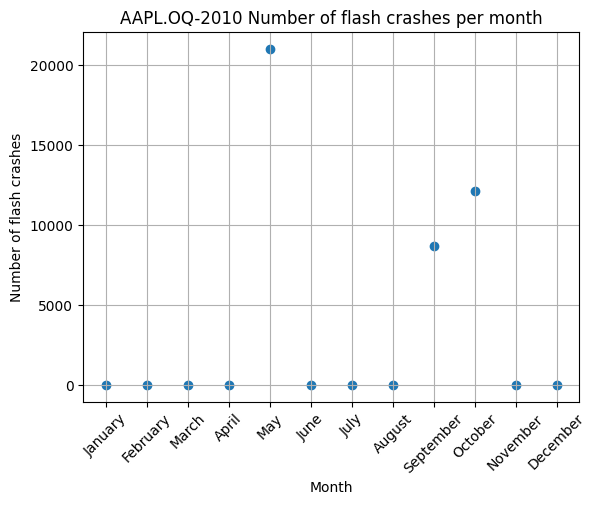

In [147]:
import calendar 
df_monthly_crash = df.resample('1M').agg({'flash_crash': 'sum'})
df_monthly_crash['month'] = df_monthly_crash.index.month
df_monthly_crash['month'] = df_monthly_crash['month'].apply(lambda x: calendar.month_name[x])
plt.scatter(df_monthly_crash['month'],df_monthly_crash['flash_crash'])
plt.xlabel("Month")
plt.ylabel("Number of flash crashes")
plt.title(ticker_name+ " Number of flash crashes per month")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [155]:
import calendar 
df_daily_crash = df.resample('1D').agg({'flash_crash': 'sum'})
df_daily_crash[df_daily_crash['flash_crash']>=1]


,flash_crash
ny_index,
2010-05-06 00:00:00-04:00,11891
2010-05-07 00:00:00-04:00,9102
2010-09-28 00:00:00-04:00,8669
2010-10-19 00:00:00-04:00,12076


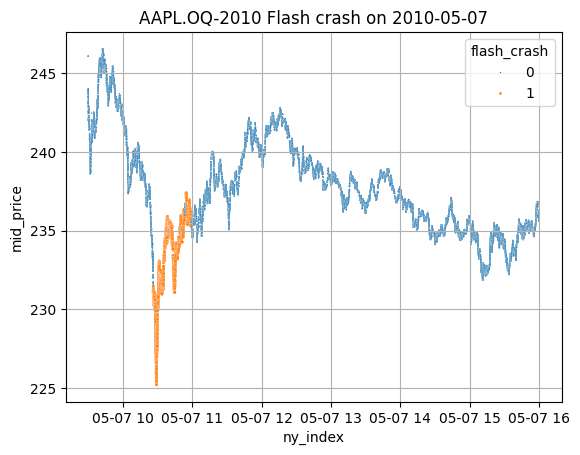

In [168]:
import seaborn as sns
df_crash1 = df[(df.index >= '2010-05-07')&(df.index <= '2010-05-08')]
sns.scatterplot(data=df_crash1, x=df_crash1.index, y='mid_price', hue='flash_crash',size='flash_crash',sizes=(4, 1))
plt.title(ticker_name+ " Flash crash on 2010-05-07")
plt.grid()

### Discussion : 
As expected, we notice that the occurences of flash crashes are very rare. In fact, with our definition of a flash crash (i.e: drop >5% within 30 minute interval), we notice only 3 months where it happened and more precisely in 4 days. After careful inspection, the first one is the famous big flash crash, the second one is on the day just after and the last two are actually just price redress at market opening.

In [171]:
## Group trades into minutes by taking sum of trade volume, mean price.. and label as flash crash if the number of trades exceed the threshold within the window
df_resampled = df.copy()
df_resampled = df_resampled.resample('1s').agg({'trade_price': 'mean', 'trade_volume': 'sum', 'ask-price': 'mean', 'bid-price': 'mean', 'ask-volume': 'sum', 'bid-volume': 'sum', 'mid_price': 'mean', 'max_price_pct_change': 'max', 'min_price_pct_change': 'min', 'flash_crash': 'max'})
df_resampled.dropna(inplace=True)
print(df_resampled.flash_crash.value_counts(normalize=True))
df_resampled[['max_price_pct_change','min_price_pct_change']].describe()
print("With sampling, df is of length : ",len(df_resampled))

flash_crash
0.0    0.984449
1.0    0.015551
Name: proportion, dtype: float64
With sampling, df is of length :  132788


#### 2) Training 
Note: Training should be done on a rolling calibration.
We cannot just perform a logistic regresssion because the flash crash actually only happens a few times so with a rolling callibration, we will mostly have one class (0: non flash crash). We can either try to label our data with a probability of crash but this needs very stong assumptions about price volatility and other metrics. Or the method we will be implementing is using the market response function. First we need a regression on a the response function, then a classification using a simple model (exceeding a magnitude threshold in values/spread)

Note: We need to use F1 score since the data is very imbalanced.

#### a) Naive approach : Use Mean squared error as loss function

In [10]:
# # Parameters
# k = 3000 # Window size
# tau_max = k # should be equal to k
# # tau_max = 5000  # Maximum lag
# threshold = 0.5  # Threshold for deviation
# num_cores = multiprocessing.cpu_count()
# # Initialize model
# model = LinearRegression()
# metrics  ={"TP":0,"TN":0,"FP":0,"FN":0}

# def compute_deviation(y_pred, y_true):
#     return ((y_pred - y_true)**2).mean()

# # Fit and predict in a rolling window
# for i in range(k, len(df)):
#     # Fit the model on the window from t to t+k
#     window = df[i-k:i-1] 
#     X_train = window 
#     X_train = setup_response_function_data(X_train)     # Response function
#     X_train.drop(columns=['prev_mid_price','prev_trade'],inplace=True) 
#     y_train,_ = compute_response_parallel(window,tau_max,num_processes=num_cores)        # Response function
#     na = np.isnan(y_train)
#     y_train[-1] = y_train[-2]
#     if not X_train.flash_crash.sum() : model.fit(X_train, y_train) # Fit the model if there is no flash crash
#     y_pred = model.predict(X_train)
#     # Calculate deviation
#     deviation = compute_deviation(y_pred, y_train)

#     # Check for flash crash
#     print(f"Deviation at {df.index[i+1]}: {deviation}")
#     if deviation > threshold:
#         print(f"Flash crash predicted at time {df.index[i+1]}")
#         print(f"Predicted response: {y_pred}")
    

#### b) Dynamic Time Warping (DTW):
DTW is a technique for measuring the similarity between two sequences, even when they have different lengths or are temporally misaligned. So we can use this function even when window and tau max are not equal

In [11]:
# # Parameters
# k = 10000  # Window size
# tau_max = k # should be equal to k
# threshold = 400  # Threshold for deviation
# num_cores = multiprocessing.cpu_count()
# # Initialize model
# model = LinearRegression()
# def compute_deviation(y_pred, y_true):
#     distance, _ = fastdtw(y_true, y_pred)
#     return distance

# # Fit and predict in a rolling window
# for i in range(k, len(df)):
#     # Fit the model on the window from t to t+k
#     window = df[i-k:i-1]
#     X_train = window
#     X_train = setup_response_function_data(X_train)     # Response function
#     X_train.drop(columns=['prev_mid_price','prev_trade'],inplace=True)
#     y_train,_ = compute_response_parallel(window,tau_max,num_processes=num_cores)        # Response function
#     na = np.isnan(y_train)
#     y_train[-1] = y_train[-2]
#     if not X_train.flash_crash.sum() : model.fit(X_train, y_train)    y_pred = model.predict(X_train)
#     # Calculate deviation
#     deviation = compute_deviation(y_pred, y_train)

#     # Check for flash crash
#     print(f"Deviation at {df.index[i+1]}: {deviation}")
#     if deviation > threshold:
#         print(f"Flash crash predicted at time {df.index[i+1]}")
#         print(f"Predicted response: {y_pred}")

#### c) Kernel Density Estimation (KDE)

In [169]:

# def compute_deviation_wasserstein(y_pred, y_true):
#     # Assuming actual_response and predicted_response are your time series data
#     kde_actual = KernelDensity(kernel='gaussian').fit(np.array(y_true).reshape(-1, 1))
#     kde_predicted = KernelDensity(kernel='gaussian').fit(np.array(y_pred).reshape(-1, 1))
#     # Evaluate the estimated density functions on a grid
#     x_grid = np.linspace(min(min(y_true), min(y_pred)),
#                         max(max(y_true), max(y_pred)), 1000)
#     log_density_actual = kde_actual.score_samples(x_grid.reshape(-1, 1))
#     log_density_predicted = kde_predicted.score_samples(x_grid.reshape(-1, 1))
#     # Calculate the Wasserstein distance between the two estimated distributions
#     distance = wasserstein_distance(np.exp(log_density_actual), np.exp(log_density_predicted))
#     return distance

# # Parameters
# k = 10000  # Window size
# tau_max = k # should be equal to k
# threshold = 0.01  # Threshold for deviation
# num_cores = multiprocessing.cpu_count()
# # Initialize model
# model = LinearRegression()

# # Fit and predict in a rolling window
# for i in range(k, len(df)):
#     # Fit the model on the window from t to t+k
#     window = df[i-k:i-1]
#     X_train = window
#     X_train = setup_response_function_data(X_train)     # Response function
#     X_train.drop(columns=['prev_mid_price','prev_trade'],inplace=True)
#     y_train,_ = compute_response_parallel(window,tau_max,num_processes=num_cores)        # Response function
#     na = np.isnan(y_train)
#     y_train[-1] = y_train[-2]
#     if not X_train.flash_crash.sum() : model.fit(X_train, y_train)   
#     y_pred = model.predict(X_train)
#     # Calculate deviation
#     deviation = compute_deviation(y_pred, y_train)

#     # Check for flash crash
#     print(f"Deviation at {df.index[i+1]}: {deviation}")
#     if deviation > threshold:
#         print(f"Flash crash predicted at time {df.index[i+1]}")
#         print(f"Predicted response: {y_pred}")

#### d) Analytical observations from the response function
- Magnitude of the Response Function
- Volatility of the Response Function
- Stability of the Response Function

In [172]:
def compute_deviation(y_pred, y_true, y_std, weight_ttest=0.5, weight_volatility=0.2, weight_stability=0.3,std_deviation_threshold = 2):
    # Response magnitude
    t_stat, p_value_t = ttest_ind(y_pred, y_true,alternative='less')
    U_stat, p_value_u = ranksums(y_pred, y_true,alternative='less')
    print("\n")
    print("p_value_t",p_value_t)
    print("p_value_u",p_value_u)
    
    # Volatility
    y_pred_volatility = np.std(y_pred)
    y_std = np.std(y_true)
    print("y_std",y_std)
    print("y_pred_volatility",y_pred_volatility)
    
    # Stability of response function
    # Calculate the coefficient of variation (CV)
    cv_true = np.std(y_true) / np.mean(y_true)
    cv_pred = np.std(y_pred) / np.mean(y_pred)
    print("cv_true",cv_true)
    print("cv_pred",cv_pred)
    
    # Calculate individual deviations
    deviation_ttest = ((p_value_t < 0.05) and (p_value_u<0.05) )
    print("deviation_ttest",deviation_ttest)
    deviation_volatility = (y_std-y_pred_volatility)/y_std
    print("deviation_volatility",deviation_volatility)
    deviation_stability = (cv_true-cv_pred)/ cv_true
    print("deviation_stability",deviation_stability)
    
    # Calculate the overall deviation
    overall_deviation = deviation_ttest * weight_ttest + deviation_volatility*weight_volatility + deviation_stability*weight_stability
    
    return overall_deviation

def check_flash_crash(deviation,threshold):
    if deviation > threshold:
        return True
    else:
        return False
def update_metrics(metrics,flash_crash,true_label):
    if flash_crash and true_label : metrics["TP"] += 1
    elif flash_crash and not true_label : metrics["FP"] += 1
    elif not flash_crash and true_label : metrics["FN"] += 1
    elif not flash_crash and not true_label : metrics["TN"] += 1
    return metrics
def f1_score(metrics):
    if (metrics["TP"]+metrics["FP"] == 0) or (metrics["TP"]+metrics["FN"] == 0) : return 0
    precision = metrics["TP"]/(metrics["TP"]+metrics["FP"])
    recall = metrics["TP"]/(metrics["TP"]+metrics["FN"])
    return 2*(precision*recall)/(precision+recall)
def accuracy(metrics):
    return (metrics["TP"]+metrics["TN"])/(metrics["TP"]+metrics["TN"]+metrics["FP"]+metrics["FN"])

In [170]:
df = df_resampled.copy()
df = df[ (df.index>= '2010-05-06 10:15') & (df.index<= '2010-05-30') ]
# Parameters
k = 3000  # Window size
tau_max = k # should be equal to k
threshold = 0.9  # Threshold for deviation
num_cores = multiprocessing.cpu_count()
# Initialize model
model = LinearRegression()
metrics  ={"TP":0,"TN":0,"FP":0,"FN":0}
y_pred_list = []
# Fit and predict in a rolling window
for i in range(k, len(df)):
    start_time = time.time()
    # Fit the model on the window from t to t+k
    X_train = df[i-k:i]
    X_train = setup_response_function_data(X_train)     # Response function
    X_train.drop(columns=['prev_mid_price','prev_trade'],inplace=True)
    y_train,y_std = compute_response_parallel(X_train,tau_max,num_processes=num_cores)      # Response function
    y_train.insert(0,0) # Response function at tau = 0 is 0 because price change is 0
    
    if not X_train.flash_crash.sum():
        X_train.drop(columns=['flash_crash'],inplace=True)
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_train)
    # Calculate deviation
    deviation = compute_deviation(y_pred, y_train,y_std)
    flash_crash = check_flash_crash(deviation,threshold) 
    metrics = update_metrics(metrics,flash_crash, df.iloc[i+1].flash_crash)

    y_pred_list.append(flash_crash )
    end_time = time.time()
    # Check for flash crash
    print(f"Deviation at {df.index[i+1]}, {deviation}, predicted flash crash: {bool(flash_crash)}, time taken: {end_time-start_time}")
    # print(f"Metrices: {metrics}")

    print(f"F1 score: {f1_score(metrics)}, Accuracy: {accuracy(metrics)}")
    if deviation > threshold:
        print(f"{bool(df.iloc[i+1].flash_crash)} Flash crash predicted at time {df.index[i+1]}")
        plt.plot(y_pred, label='Predicted response')
        plt.plot(y_train, label='Actual response')
        plt.legend()
        plt.show()
    




p_value_t 0.5000000000024181
p_value_u 0.9999999999999986
y_std 0.2684239811631973
y_pred_volatility 0.07270260325029065
cv_true 2.079692633058899
cv_pred 0.5632845013645442
deviation_ttest False
deviation_volatility 0.7291501193923181
deviation_stability 0.7291501193923826
Deviation at 2010-05-06 12:52:04-04:00, 0.3645750596961784, predicted flash crash: False, time taken: 1.816356897354126
F1 score: 0, Accuracy: 1.0


p_value_t 0.5000000000016182
p_value_u 1.0
y_std 0.3044964229912246
y_pred_volatility 0.08815647802702495
cv_true 2.1588583410798954
cv_pred 0.6250232631281927
deviation_ttest False
deviation_volatility 0.7104843559046815
deviation_stability 0.7104843559047297
Deviation at 2010-05-06 12:52:08-04:00, 0.35524217795235524, predicted flash crash: False, time taken: 1.5778801441192627
F1 score: 0, Accuracy: 1.0


p_value_t 0.5000000000002478
p_value_u 1.0
y_std 0.3746144348374959
y_pred_volatility 0.12233337844463217
cv_true 2.425296874536925
cv_pred 0.7920003416899938
dev

KeyboardInterrupt: 